# MadMiner particle physics tutorial

# Part 1: Setup

Johann Brehmer, Felix Kling, Irina Espejo, and Kyle Cranmer 2018-2019

Welcome to the MadMiner particle-physics tutorial! It consists of six numbered notebooks. They build on each other, so please go through them in the right order, starting with this notebook.

In this first part, we'll show how to set up the parameter space and define a morphing setups -- typically the first steps in a MadMiner analysis.

This tutorial does not try to explain the theory behind the tool. To understand what MadMiner is doing, please have a look at some papers first. In
["Constraining Effective Field Theories With Machine Learning"](https://arxiv.org/abs/1805.00013)
we explain the basic idea of most of the methods presented here, while ["A Guide to Constraining Effective Field Theories With Machine Learning"](https://arxiv.org/abs/1805.00020) is an extensive 65-page handbook going through the details.

## 0. Preparations

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import logging
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

from madminer.core import MadMiner
from madminer.plotting import plot_2d_morphing_basis


MadMiner uses the Python `logging` module to provide additional information and debugging output. You can choose how much of this output you want to see by switching the level in the following lines to `logging.DEBUG` or `logging.WARNING`.

In [2]:
# MadMiner output
logging.basicConfig(
    format='%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s',
    datefmt='%H:%M',
    level=logging.INFO
)

# Output of all other modules (e.g. matplotlib)
for key in logging.Logger.manager.loggerDict:
    if "madminer" not in key:
        logging.getLogger(key).setLevel(logging.WARNING)

## 1. Input data

As an example process, we'll simulate VBF Higgs production with a decay into two photons. We'll try to measure two EFT coefficients that affect this process.

Have a look at the `cards` folder. You'll find text files ("cards") that specify the process simulation in typical MadGraph convention.

## 2. Define parameter space

After creating a `MadMiner` instance, the first important step is the definition of the parameter space. Each model parameter is characterized by a name as well as the LHA block and ID.

If morphing is used, one also has to specify the maximal power with which the parameter contributes to the squared matrix element. For instance, a parameter that contributes only to one vertex, will typically have `morphing_max_power=2`, while a parameter that contributes to two vertices usually has `morphing_max_power=4`. Exceptions arise for instance when the interference effects between the SM and dimension-six operators are modelled, but the square of the dimension-six amplitude (subleading in 1/Lambda) is not taken into account, in which case `morphing_max_power=1`. The `parameter_range` argument defines the range of parameter values that are used for the automatic optimization of the morphing basis.

Finally, the parameter values theta used internally by MadMiner and the parameter values written to the param_card (or reweight_card) given to MadGraph do not have to be exactly the same. With the option `parm_card_transform`, the user can supply a one-parameter function that maps a parameter value theta to the value given to MadGraph. This string is a python expression, in which `theta` is parsed as the parameter value. For instance, if the internal parameters are in the range (0, 1), but should be linearly scaled to (0, 100) in the param_card, one would have to use `param_card_transform="100*theta"`.

In [6]:
miner = MadMiner()

miner.add_parameter(
    lha_block='dim6',
    lha_id=2,
    parameter_name='CWL2',
    morphing_max_power=2,
    param_card_transform="16.52*theta",
    parameter_range=(-20.,20.)
)
miner.add_parameter(
    lha_block='dim6',
    lha_id=5,
    parameter_name='CPWL2',
    morphing_max_power=2,
    param_card_transform="16.52*theta",
    parameter_range=(-20.,20.0)
)

13:46 madminer.core        INFO    Added parameter CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-20.0, 20.0))
13:46 madminer.core        INFO    Added parameter CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-20.0, 20.0))


## 3. Define benchmarks (evaluation points for |M|^2) manually

The next step is the definition of all the points at which the weights (squared matrix elements) should be evaluated by MadGraph. We call these points "benchmarks". One can define benchmarks by hand:

In [7]:
miner.add_benchmark({'CWL2':0., 'CPWL2':0.}, 'sm')
miner.add_benchmark({'CWL2':15., 'CPWL2':0.}, 'w')
miner.add_benchmark({'CWL2':-15., 'CPWL2':0.}, 'neg_w')
miner.add_benchmark({'CWL2':0., 'CPWL2':15.}, 'ww')
miner.add_benchmark({'CWL2':0., 'CPWL2':-15.}, 'neg_ww')

13:46 madminer.core        INFO    Added benchmark sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00)
13:46 madminer.core        INFO    Added benchmark w: CWL2 = 15.00, CPWL2 = 0.00e+00)
13:46 madminer.core        INFO    Added benchmark neg_w: CWL2 = -1.50e+01, CPWL2 = 0.00e+00)
13:46 madminer.core        INFO    Added benchmark ww: CWL2 = 0.00e+00, CPWL2 = 15.00)
13:46 madminer.core        INFO    Added benchmark neg_ww: CWL2 = 0.00e+00, CPWL2 = -1.50e+01)


## 4. Morphing

Morphing is a powerful technique that allows for the fast and exact interpolation of event weights (or any derived quantity) from a set of original benchmark points (the "morphing basis") to anywhere in theory parameter space. This procedure depends on the powers with which the parameters affect the differential cross sections (this is why `add_parameter()` wants to know about this). Please see Sec. II.C.2 of ["A Guide to Constraining Effective Field Theories With Machine Learning"](https://arxiv.org/abs/1805.00020) for an explanation of the techniqe.

Morphing is not strictly necessary to run MadMiner, but it makes life easier in so many ways (and many methods are so far only implemented for morphing-based problems). We strongly recommend to use this wherever possible.

To activate morphing, the function `set_morphing` has to be called. With the option `include_existing_benchmarks=True`, MadMiner will keep all the benchmark points defined beforehand and run a simple optimization algorithm to fix the remaining ones for the basis (which may be none). Otherwise, MadMiner will optimize the full basis and forget about all previously defined benchmark points.

The other important keyword is `max_overall_power`. This sets the maximal combined power with which all parameters together contribute to the squared matrix element (cross section). This constraint is in addition to the `morphing_max_power` keyword of `add_parameter()` (see above). For instance, if there are two parameters of interest `a` and `b`, and it is known that there are contributions proportional to `1` (constant), `a`, `a^2`, `b`, `b^2`, and `ab`, then `max_overall_power=2`. If there are also contributions proportional to `a^2 b`, `a b^2`, and `a^2 b^2`, then `max_overall_power=4`.

In [8]:
miner.set_morphing(include_existing_benchmarks=True, max_overall_power=2)

13:46 madminer.core        INFO    Optimizing basis for morphing
13:46 madminer.core        INFO    Set up morphing with 2 parameters, 6 morphing components, 5 predefined basis points, and 1 new basis points


Let's have a look at the resulting morphing basis and the "morphing error", i.e. the sum of squared morphing weights as a function of the parameter space. The black dots mark the benchmarks at which the squared matrix element will be evaluated when MadGraph is run. In between them, the morphing will interpolate. Since the morphing knows about the functional form of the amplitudes, there is only a small numerical uncertainty in this interpolation, we expect that the color in this plot is indicative of this uncertainty.

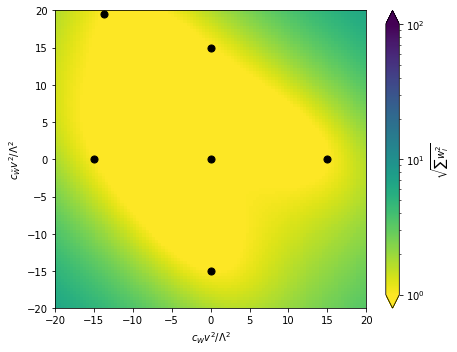

In [10]:
fig = plot_2d_morphing_basis(
    miner.morpher,
    xlabel=r'$c_{W} v^2 / \Lambda^2$',
    ylabel=r'$c_{\tilde{W}} v^2 / \Lambda^2$',
    xrange=(-20.,20.),
    yrange=(-20.,20.)
)

Note that squared weights (the colormap here) up to 1000 or even 10000 can still be perfectly fine and are in fact sometimes unavoidable.

## 5. Save setup

The parameter space, benchmark points, and morphing setup are saved in a HDF5 file:

In [11]:
miner.save('data/setup.h5')

13:47 madminer.core        INFO    Saving setup (including morphing) to data/setup.h5


They can now be loaded again with `miner.load(filename)`.

That's it for the setup (we'll only add one step when talking about systematic uncertainties in part 5 of the tutorial). Please continue with part 2a **or** part 2b, depending on whether you want to run the faster parton-level analysis or the more realistic Delphes-level analysis.